**Classification of birds to species with Convolutional Neural Network**

Learning paradigm: (strong) supervised learning

<u>This notebook documents 2. experiment conducted in 10th of April 2022</u>.

Dataset I work with is: https://www.kaggle.com/datasets/gpiosenka/100-bird-species/. Check what Convolutional neural networks are all about at https://d2l.ai/chapter_convolutional-neural-networks/index.html before making changes to this notebook.

Dataset was extracted to the same folder as this notebook was placed in.

**What is our task here**

Task here was to build more powerful CNN than one from the first experiment. Task was to speed up learning process and achieve a better accuracy in classification task.

In [1]:
# import utilities
import os # to get relative path to project directory and therefore dataset
import matplotlib.pyplot as plt # to evaluate model performance
import numpy as np # utilities needed to visualize model performance
import pandas as pd # utilities needed to visualize model performance
from sklearn.metrics import classification_report # visualize model performance

import tensorflow as tf # import tensorflow
from keras.callbacks import EarlyStopping # stop training when you have no progress
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator # work with data through the facade
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, Dropout # input, output, hidden layers, activation...
from tensorflow.keras.layers import Conv2D, MaxPooling2D # convolutional layer and max pooling
from tensorflow.keras.layers import BatchNormalization # optimization, regularization technique

Training set consists of 58 388 RGB images (that means 3 channels), 224px x 224px. Validation set consists of 2000 images and test set consists of 2000 images. There are 356 unique bird species in a training dataset. There are 400 unique bird species in validation dataset and 400 bird species in test dataset too. Further statistics can be found in attached document.

In [2]:
BASE_DIR = os.getcwd() # extract dataset from Kaggle to same folder as you have in this notebook

TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'testing')

In [3]:
TRAIN_CATEGORIES = os.listdir(TRAIN_DIR)
Train_Category_count = len(TRAIN_CATEGORIES) # # 85 % of males, training set is 97 % of the whole dataset

VAL_CATEGORIES = os.listdir(VALIDATION_DIR)
Val_Category_count = len(VAL_CATEGORIES)

TEST_CATEGORIES = os.listdir(TEST_DIR)
Test_Category_count = len(TEST_CATEGORIES)

Applying standard rescale factor by which all data values would be multiplied. We're doing this because we deal with images in RGB, where pixel values vary between 0 and 255. Such values would be too high for our model to process. This is why I rescale them to interval 0-1.

Attribute "shuffle" set to True and passed to ImageDataGenerator means application of mini-batch optimization technique.

In [4]:
data_iterator = ImageDataGenerator(rescale=1./255,)

In [5]:
train_data = data_iterator.flow_from_directory(
    directory = TRAIN_DIR, 
    batch_size = 32, 
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

validation_data = data_iterator.flow_from_directory(
    directory = VALIDATION_DIR, 
    batch_size = 32,
    shuffle = True,
    class_mode="categorical",
    target_size=(224, 224))

test_data = data_iterator.flow_from_directory(
    directory = TEST_DIR,
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224))

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


**Architecture of this Convolutional Neural Network**

1. Convolutional layer - to extract patterns and abstract from low-level features of the images
2. Activation layer - activation functions with a same purpose as they have in Multilayer perceptrons. 
3. Pooling layer - optimization with Max pooling.
4. Normalization layer - batch normalization as optimization technique. Conducted after activation, before another convolution
5. Dense layer - fully connected layer of the MLP.

Input to this convolutional network are RGB images 224 x 224 px with 3 channels. First convolutional layer works with 3 channels, but this does not mean all convolutional layers have to work with these same 3 channels (they usually create activation maps with more channels).

Best practice is to use same activation function across all layers. 

**Strategy of my Learning Process**

1. Setup, build and run my Convolutional Neural Network.
2. Check my model performance.
3. Conduct more experiments with probably different set of hyperparameters.

In [6]:
tf.keras.backend.clear_session()

IMAGE = load_img(os.getcwd() + "\\testing\\ABBOTTS BABBLER\\1.jpg")
IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape

model = tf.keras.models.Sequential()

# lowest convolutional layer for identification of the edges of birds
# input shape is provided, so no deferred initialization https://d2l.ai/chapter_deep-learning-computation/deferred-init.html
model.add(Conv2D(32, (3, 3), padding='same', input_shape=SHAPE))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# convolutional layer to learn and store mid-level features of the bird species
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# highest convolutional layer to store complex information about the look of birds
model.add(Conv2D(32, (3, 3), padding='same')) 
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization())

# and finally MLP
model.add(Flatten()) 
model.add(Dense(32)) 
model.add(Activation('tanh'))
model.add(Dense(Train_Category_count)) 
model.add(Activation('softmax'))

model.compile(optimizer = "adam",
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

EPOCHS = 5

# stop if there is no big training progress towards good accuracy after 5 epochs
# use it if you're going to learn model through more than 5 epochs (e.g. 10)
# stop training if the model cannot pass at least 0.5 accuracy after 5 epochs
earlyStopCallback = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=5, min_delta = 1, baseline=0.5)

# do not specify batch sizes here, because generators declared above generate batches
history = model.fit(train_data, epochs=EPOCHS, validation_data = validation_data, 
                    steps_per_epoch=len(train_data), validation_steps = len(validation_data), callbacks=[earlyStopCallback])

Epoch 1/5
1825/1825 [==============================] - 1111s 609ms/step - loss: 5.6467 - accuracy: 0.0163 - val_loss: 5.3468 - val_accuracy: 0.0280
Epoch 2/5
1825/1825 [==============================] - 1116s 611ms/step - loss: 5.2173 - accuracy: 0.0368 - val_loss: 5.0752 - val_accuracy: 0.0485
Epoch 3/5
1825/1825 [==============================] - 1216s 666ms/step - loss: 4.9528 - accuracy: 0.0580 - val_loss: 4.7350 - val_accuracy: 0.0765
Epoch 4/5
1825/1825 [==============================] - 1235s 677ms/step - loss: 4.7514 - accuracy: 0.0761 - val_loss: 4.6120 - val_accuracy: 0.0775
Epoch 5/5
1825/1825 [==============================] - 1180s 647ms/step - loss: 4.6465 - accuracy: 0.0864 - val_loss: 4.4989 - val_accuracy: 0.0970
Epoch 5: early stopping


**Model Evaluation**

This network is simply unable to classify. Validation error is smaller than on a training set. We must increase its computational power and classification accuracy in next experiment.

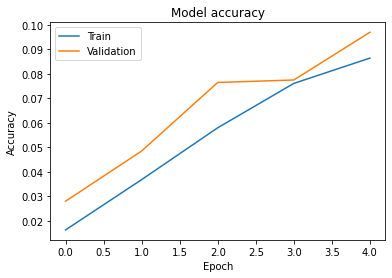

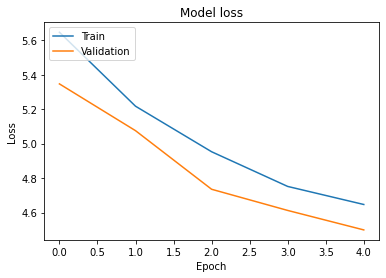

63/63 [==============================] - 9s 146ms/step - loss: 4.4410 - accuracy: 0.1040
Test loss: 4.441006183624268
Test accuracy: 0.10400000214576721


AttributeError: 'Sequential' object has no attribute 'params'

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# save model for later use

model.save(os.getcwd() + '/model-from-2-experiment.h5')